# Plot maps of T-S differences between obs and model simulations

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
from netCDF4 import Dataset
import gsw


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'

In [2]:
client = Client()
client

<Client: 'tcp://127.0.0.1:46059' processes=6 threads=18, memory=180.00 GiB>

List of obs and model units. 

| Oservations/Model | Temperature units | Salinity units |
| --- | --- | --- |
| Pauthenet et al. (2021) | in situ temperature [C] | Practical salinity [psu] |
| Schmidtko et a. (2014) | Conservative temperature [C] | Absolute salinity [g/kg] |
| --- | --- | --- |
| ACCESS-OM2-01 |  Conservative temperature [K] | Practical salinity [psu]  |


Read in perturbation and control model data. 

In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# realistic calving + conservative temperature + tfreezing as in GPC006 / calving put in runoff array - test
Tfreezing_min_calv_2 = 'accessom2-GPC013'
# idem as GPC013 but Gade line formulation
TGade = 'accessom2-GPC015'
# idem as GPC015 plus Merino's ICB 
TGade_icb = 'accessom2-GPC017'

# Read in Pedros database. 
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)
#dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC013/']
#cc.database.build_index(dir_list,basal_melt_session)


start_time='2150-01-01'
end_time='2170-12-31'
lat_slice = slice(-80,-59)

Read in observations, convert units, and concatenate to same longitude as model. 

In [5]:
# read in observations from Pauthenet at al. (2021)
obsfile = '/g/data/e14/hd4873/obs_data/pauthenetetal2021/TS_Climato_Antarctic60S.nc'
obs = xr.open_dataset(obsfile).mean(dim='time')

# convert in-situ temperature to conservative temperature
p = gsw.p_from_z(-obs.depth, obs.lat)
# first we need absolute salinity
AS = gsw.SA_from_SP(obs.Sal, p, obs.lon, obs.lat)
# now we can get CT from in-situ temp
obs['Temp'] = gsw.CT_from_t(AS, obs.Temp, p)
del AS # delete absolute salinity as we don't need it

# concat observations onto model grid.
x = obs.lon.values
x[x> 80] = x[x>80]-360
# replace lon coordinate values with these modified longitude values
obs['lon'] = x
# now concatenate temp and salinity so that it goes from -280 to 80 like access
obs_temp = xr.concat((obs.Temp[521:,:,:], obs.Temp[0:521,:,:]), dim='lon')
obs_salt = xr.concat((obs.Sal[521:,:,:], obs.Sal[0:521,:,:]), dim='lon')
#obs_temp[:,:,0].T.plot()
#plt.show()

Now interpolate obs onto model grid. Note, this is a very basic interpolation, should probably just use `xesfm`. 

In [6]:
# read in temperature variables for grid purposes only
start_time='2150-01-01'
end_time='2150-02-31'
temp_cntl = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',
                               start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice) - 273.15

def interp_obs(obs,model_lat,model_lon): 
    obs_new = obs.interp(lat = model_lat, lon = model_lon)
    return obs_new

obs_temp = interp_obs(obs_temp,temp_cntl.yt_ocean,temp_cntl.xt_ocean)
obs_salt = interp_obs(obs_salt,temp_cntl.yt_ocean,temp_cntl.xt_ocean)

## Circumpolar maps

Define function to calculate depth-averaged temperature and salinity anomalies. 

In [7]:
# first calculate depth-averaged mean temperature and salnity
def depth_average(sim, session, zslice, start_time, end_time):
    lat_slice = slice(-80,-59)
    temp = cc.querying.getvar(sim, 'temp', session, frequency='1 monthly',
                               start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice) - 273.15
    salt = cc.querying.getvar(sim, 'salt', session, frequency='1 monthly',
                               start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice)
    dzt = cc.querying.getvar(sim, 'dzt', session, frequency='1 monthly',
                               start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice)
    
    dzt_slice = dzt.sel(st_ocean=zslice)/dzt.sel(st_ocean=zslice).sum(dim='st_ocean')
    temp_mean = (temp.sel(st_ocean=zslice)*dzt_slice).sum(dim='st_ocean').mean(dim='time')#.load()
    temp_mean = temp_mean.where(temp_mean != 0., np.nan).load()
    salt_mean = (salt.sel(st_ocean=zslice)*dzt_slice).sum(dim='st_ocean').mean(dim='time')#.load()
    salt_mean = salt_mean.where(salt_mean != 0., np.nan).load()
    
    # calculate anomalies
    temp_a = temp_mean - obs_temp.sel(depth=zslice).mean(dim='depth').T
    salt_a = salt_mean - obs_salt.sel(depth=zslice).mean(dim='depth').T
    
    return temp_a, salt_a

Define figure functions and other plotting data. 

In [11]:
fontsize=16
subplot_labels = ['a)','b)','c)','d)','e)','f)','g)','h)']

# topography data for plotting:
data_path = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/'
htfile = data_path + 'output196/ocean/ocean_grid.nc'
ht = xr.open_dataset(htfile).ht.sel(yt_ocean=slice(-90,-55)).load()
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

# define circle 
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

def map_elements(axes):
    for i, ax in enumerate(axes.flatten()):
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
        ax.set_extent([-280, 80, -90, -60], ccrs.PlateCarree())
        #if i <= 3:
        #    ax.set_title(subplot_titles[i],fontsize=16)
        ax.text(0.1, 0.95, subplot_labels[i],fontsize=20, fontweight='bold',transform = ax.transAxes)
        
def plot_colorbar(fig,axes_loc,cb_item,label):
    cbaxes = fig.add_axes(axes_loc)
    cbar = plt.colorbar(cb_item, cax = cbaxes, orientation = 'vertical',extend = 'both', shrink=0.5)
    cbar.set_label(label,fontsize=fontsize,labelpad=3)
    cbar.ax.tick_params(labelsize=14)
    return cbar

def figure_ts_zrange(z_range,obs_temp,obs_salt, sim, session, start_times, end_times):
    plt.rcParams['font.size'] = 16
    fig,axes = plt.subplots(2,4,figsize=(23,12),subplot_kw={'projection': ccrs.SouthPolarStereo()})
    plt.subplots_adjust(wspace=0.02, hspace=0.01)
    map_elements(axes)
    vminT, vmaxT = -2, 3
    vminS, vmaxS = 33.8, 34.8
    #vminT, vmaxT = -2, 3
    #vminS, vmaxS = 34.0, 34.8
    cmapT, cmapS, cmapA = cmocean.thermal, cmocean.haline, cmocean.balance
    vminTa, vmaxTa = -1.5, 1.5
    vminSa, vmaxSa = -0.4, 0.4
    zslice = slice(z_range[0],z_range[1])
    
    for i, ax in enumerate(axes.flatten()):
        ax.text(0.55, 0.5, f'{z_range[0]}-{z_range[1]}m', ha='center', va='center', transform = ax.transAxes)
    
    # plot observations
    cb_varT = axes[0,0].pcolormesh(obs_temp.xt_ocean, obs_temp.yt_ocean, obs_temp.sel(depth=zslice).mean(dim='depth').T,
                   cmap = cmapT, vmin=vminT, vmax=vmaxT, 
                   transform = ccrs.PlateCarree())
    cb_varS = axes[1,0].pcolormesh(obs_salt.xt_ocean, obs_salt.yt_ocean, obs_salt.sel(depth=zslice).mean(dim='depth').T,
               cmap = cmapS, vmin=vminS, vmax=vmaxS, 
               transform = ccrs.PlateCarree())
    plot_colorbar(fig,[0.08, 0.55, 0.010, 0.3],cb_varT,'Conservative temperature (\u00b0C)')
    plot_colorbar(fig,[0.08, 0.16, 0.010, 0.3],cb_varS,'Practical salinity (psu)')
    
    # read in control temp and salt anomalies and plot
    temp_a, salt_a = depth_average(control, master_session, zslice, '2154-01-10', '2158-12-20')
    cb_anomT = axes[0,1].pcolormesh(temp_a.xt_ocean, temp_a.yt_ocean, temp_a,
                               cmap = cmapA, vmin=vminTa, vmax=vmaxTa,transform = ccrs.PlateCarree())
    cb_anomS = axes[1,1].pcolormesh(salt_a.xt_ocean, salt_a.yt_ocean, salt_a,
                           cmap = cmocean.diff, vmin=vminSa, vmax=vmaxSa, 
                           transform = ccrs.PlateCarree())
    axes[0,1].set_title('RYF - Obs',fontsize=16)
    
    for i in range(2):
        temp_a, salt_a = depth_average(sim, session, zslice, start_times[i], end_times[i])
        axes[0,i+2].pcolormesh(temp_a.xt_ocean, temp_a.yt_ocean, temp_a,
                               cmap = cmapA, vmin=vminTa, vmax=vmaxTa,transform = ccrs.PlateCarree())
        axes[1,i+2].pcolormesh(salt_a.xt_ocean, salt_a.yt_ocean, salt_a,
                               cmap = cmocean.diff, vmin=vminSa, vmax=vmaxSa, 
                               transform = ccrs.PlateCarree())
        axes[0,i+2].set_title(f'{sim[10:]} - Obs\n Years {int(start_times[i][0:4])-2150+1}-{int(end_times[i][0:4])-2150+1}',fontsize=16)
        plot_colorbar(fig,[0.91, 0.55, 0.010, 0.3],cb_anomT,'$\Delta$CT (\u00b0C)')
        plot_colorbar(fig,[0.91, 0.16, 0.010, 0.3],cb_anomS,'$\Delta$PS (psu)')
        
    return fig, axes

Plot figures

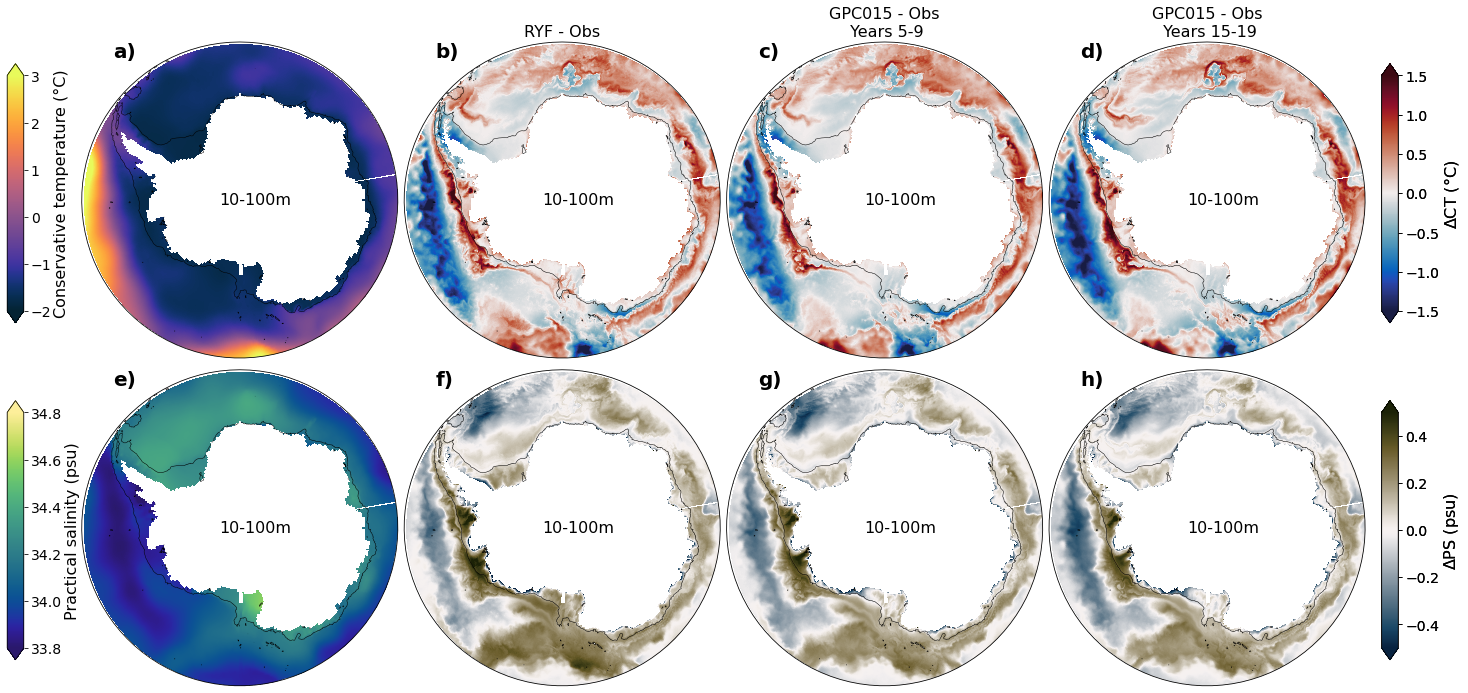

CPU times: user 7min 21s, sys: 21.1 s, total: 7min 42s
Wall time: 10min 8s


In [47]:
%%time
start_times=['2154-01-10','2164-01-10']
end_times=['2158-12-20','2168-12-20']
z_range=[10,100] # maximum range of the Pauthenet et al. (2021) data is 10-380 m bsl.  
sim, sess = TGade, basal_melt_session

fig, axes = figure_ts_zrange(z_range, obs_temp, obs_salt, sim, sess, start_times, end_times)

plt.show()

VariableNotFoundError: No files were found containing 'temp' in the 'accessom2-GPC017' experiment

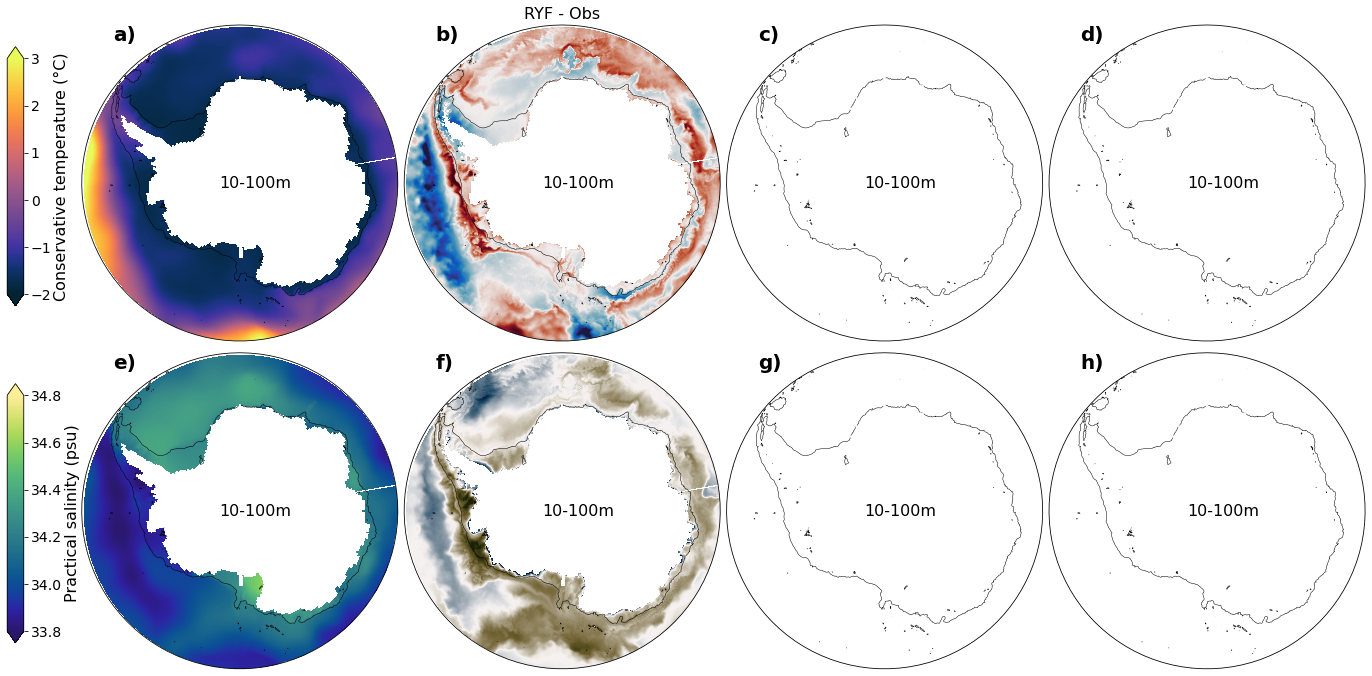

In [45]:
%%time
start_times=['2154-01-10','2164-01-10']
end_times=['2158-12-20','2168-12-20']
z_range=[10,100] # maximum range of the Pauthenet et al. (2021) data is 10-380 m bsl.  
sim, sess = TGade_icb_10, basal_melt_session

fig, axes = figure_ts_zrange(z_range, obs_temp, obs_salt, sim, sess, start_times, end_times)

plt.show()

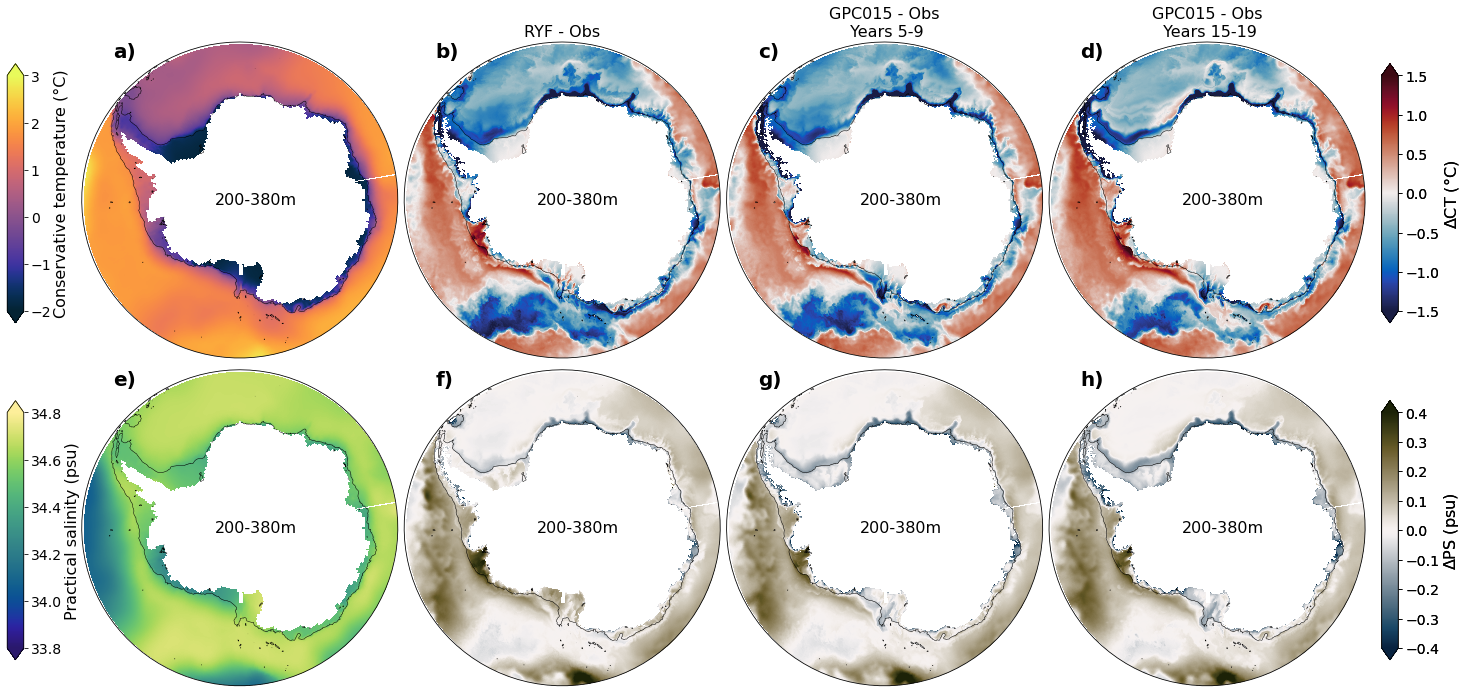

CPU times: user 4min 26s, sys: 13.1 s, total: 4min 39s
Wall time: 5min 45s


In [12]:
%%time
start_times=['2154-01-10','2164-01-10']
end_times=['2158-12-20','2168-12-20']
z_range=[200,380] # maximum range of the Pauthenet et al. (2021) data is 10-380 m bsl.  
sim, sess = TGade, basal_melt_session

fig, axes = figure_ts_zrange(z_range, obs_temp, obs_salt, sim, sess, start_times, end_times)

plt.show()

In [ ]:
%%time
start_times=['2154-01-10','2164-01-10']
end_times=['2158-12-20','2168-12-20']
z_range=[200,380] # maximum range of the Pauthenet et al. (2021) data is 10-380 m bsl.  
sim, sess = TGade_icb, basal_melt_session

fig, axes = figure_ts_zrange(z_range, obs_temp, obs_salt, sim, sess, start_times, end_times)

plt.show()

#### All 3 simulations but only first 2 years

In [14]:
def figure_ts_zrange(z_range,obs_temp,obs_salt, sim, session, start_times, end_times):
    plt.rcParams['font.size'] = 16
    fig,axes = plt.subplots(2,4,figsize=(23,12),subplot_kw={'projection': ccrs.SouthPolarStereo()})
    plt.subplots_adjust(wspace=0.02, hspace=0.01)
    map_elements(axes)
    vminT, vmaxT = -2, 3
    vminS, vmaxS = 33.8, 34.8
    #vminT, vmaxT = -2, 3
    #vminS, vmaxS = 34.0, 34.8
    cmapT, cmapS, cmapA = cmocean.thermal, cmocean.haline, cmocean.balance
    vminTa, vmaxTa = -1.5, 1.5
    vminSa, vmaxSa = -0.4, 0.4
    zslice = slice(z_range[0],z_range[1])
    
    for i, ax in enumerate(axes.flatten()):
        ax.text(0.55, 0.5, f'{z_range[0]}-{z_range[1]}m', ha='center', va='center', transform = ax.transAxes)
    
    # plot observations
    cb_varT = axes[0,0].pcolormesh(obs_temp.xt_ocean, obs_temp.yt_ocean, obs_temp.sel(depth=zslice).mean(dim='depth').T,
                   cmap = cmapT, vmin=vminT, vmax=vmaxT, 
                   transform = ccrs.PlateCarree())
    cb_varS = axes[1,0].pcolormesh(obs_salt.xt_ocean, obs_salt.yt_ocean, obs_salt.sel(depth=zslice).mean(dim='depth').T,
               cmap = cmapS, vmin=vminS, vmax=vmaxS, 
               transform = ccrs.PlateCarree())
    plot_colorbar(fig,[0.08, 0.55, 0.010, 0.3],cb_varT,'Conservative temperature (\u00b0C)')
    plot_colorbar(fig,[0.08, 0.16, 0.010, 0.3],cb_varS,'Practical salinity (psu)')
    
    # read in control temp and salt anomalies and plot
    temp_a, salt_a = depth_average(control, master_session, zslice, start_times, end_times)
    cb_anomT = axes[0,1].pcolormesh(temp_a.xt_ocean, temp_a.yt_ocean, temp_a,
                               cmap = cmapA, vmin=vminTa, vmax=vmaxTa,transform = ccrs.PlateCarree())
    cb_anomS = axes[1,1].pcolormesh(salt_a.xt_ocean, salt_a.yt_ocean, salt_a,
                           cmap = cmocean.diff, vmin=vminSa, vmax=vmaxSa, 
                           transform = ccrs.PlateCarree())
    axes[0,1].set_title('RYF - Obs',fontsize=16)
    
    for i in range(2):
        temp_a, salt_a = depth_average(sim[i], session, zslice, start_times, end_times)
        axes[0,i+2].pcolormesh(temp_a.xt_ocean, temp_a.yt_ocean, temp_a,
                               cmap = cmapA, vmin=vminTa, vmax=vmaxTa,transform = ccrs.PlateCarree())
        axes[1,i+2].pcolormesh(salt_a.xt_ocean, salt_a.yt_ocean, salt_a,
                               cmap = cmocean.diff, vmin=vminSa, vmax=vmaxSa, 
                               transform = ccrs.PlateCarree())
        axes[0,i+2].set_title(f'{sim[i][10:]} - Obs\n Years {int(start_times[0:4])-2150+1}-{int(end_times[0:4])-2150+1}',fontsize=16)
        plot_colorbar(fig,[0.91, 0.55, 0.010, 0.3],cb_anomT,'$\Delta$CT (\u00b0C)')
        plot_colorbar(fig,[0.91, 0.16, 0.010, 0.3],cb_anomS,'$\Delta$PS (psu)')
        
    return fig, axes

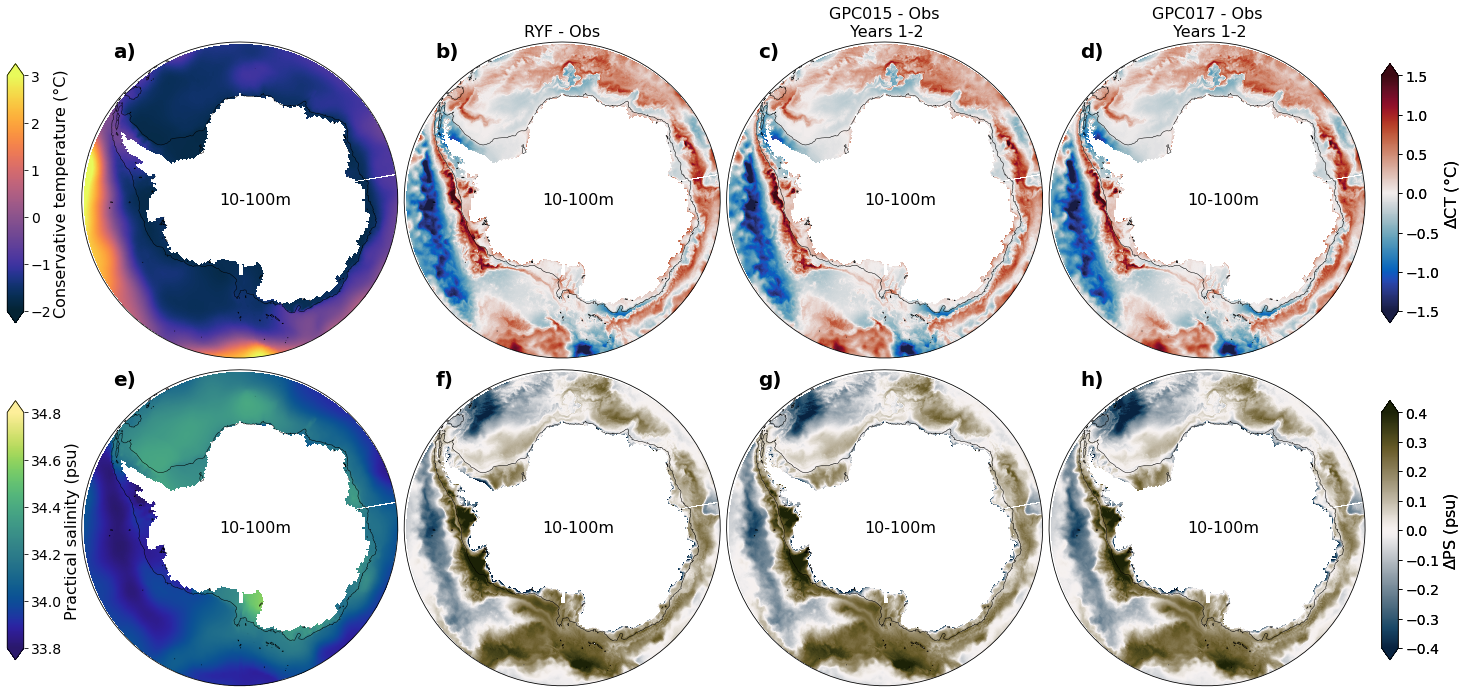

CPU times: user 3min 21s, sys: 9.97 s, total: 3min 31s
Wall time: 4min 28s


In [15]:
%%time
start_times='2150-01-10'
end_times='2151-12-20'
z_range=[10,100] # maximum range of the Pauthenet et al. (2021) data is 10-380 m bsl.  
sim, sess = [TGade,TGade_icb], basal_melt_session

fig, axes = figure_ts_zrange(z_range, obs_temp, obs_salt, sim, sess, start_times, end_times)

plt.show()

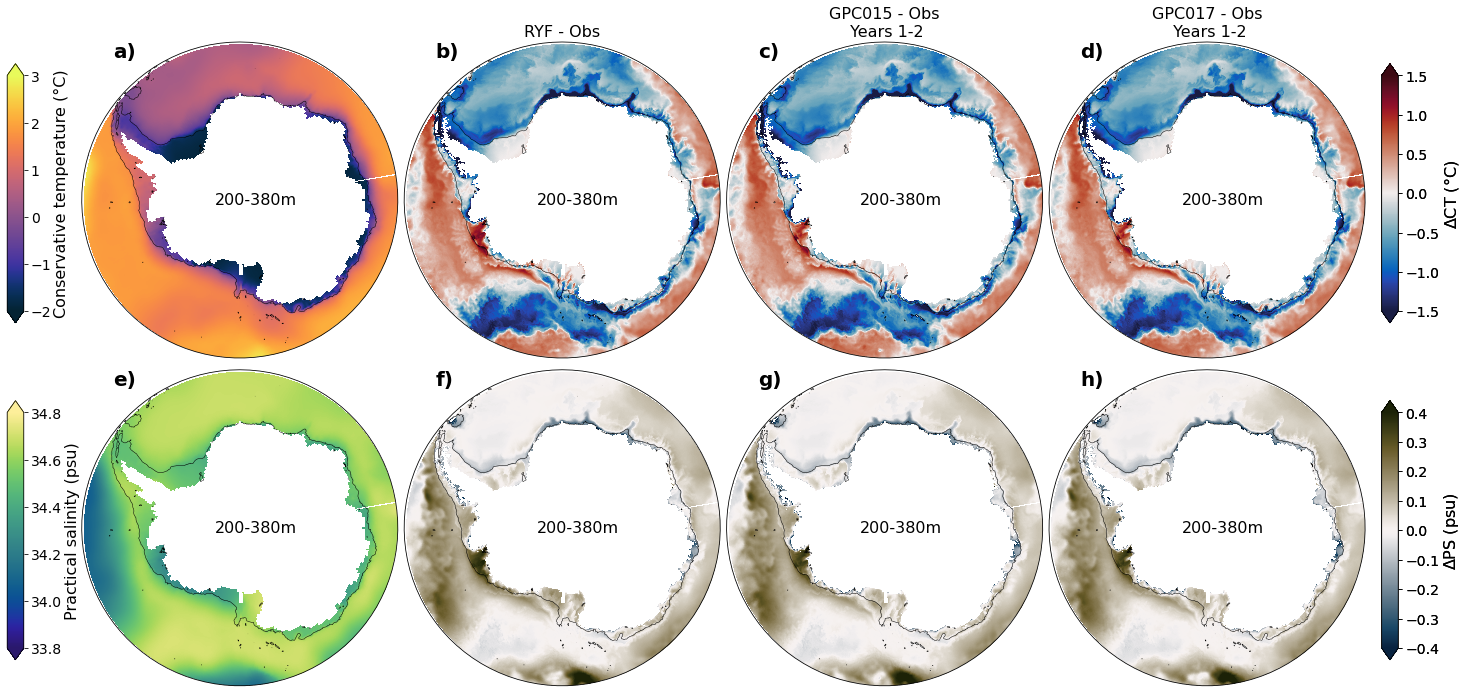

CPU times: user 2min 6s, sys: 7.62 s, total: 2min 14s
Wall time: 2min 34s


In [16]:
%%time
start_times='2150-01-10'
end_times='2151-12-20'
z_range=[200,380] # maximum range of the Pauthenet et al. (2021) data is 10-380 m bsl.  
sim, sess = [TGade,TGade_icb], basal_melt_session

fig, axes = figure_ts_zrange(z_range, obs_temp, obs_salt, sim, sess, start_times, end_times)

plt.show()

## Transects

In [17]:
# read in observations from Pauthenet at al. (2021)
obsfile = '/g/data/e14/hd4873/obs_data/pauthenetetal2021/TS_Climato_Antarctic60S.nc'
obs = xr.open_dataset(obsfile).mean(dim='time')

# convert in-situ temperature to conservative temperature
p = gsw.p_from_z(-obs.depth, obs.lat)
# first we need absolute salinity
AS = gsw.SA_from_SP(obs.Sal, p, obs.lon, obs.lat)
# now we can get CT from in-situ temp
obs['Temp'] = gsw.CT_from_t(AS, obs.Temp, p)
del AS # delete absolute salinity as we don't need it

Now interpolate obs vertically onto model grid. Note, this is a very basic interpolation, should probably just use `xesfm`. 

In [29]:
# read in temperature variables for grid purposes only
start_time='2150-01-01'
end_time='2150-02-31'
temp_cntl = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',
                               start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice) - 273.15

def interp_obs(obs,model_depth): 
    obs_new = obs.interp(depth = model_depth)
    return obs_new

Define function to read in model temp/salt. 

In [30]:
def transect_average(sim, session, lon, start_time, end_time):
    lat_slice = slice(-80,-59)
    temp = cc.querying.getvar(sim, 'temp', session, frequency='1 monthly',
                               start_time=start_time, end_time=end_time).sel(xt_ocean=lon, method='nearest').sel(yt_ocean=lat_slice) - 273.15
    salt = cc.querying.getvar(sim, 'salt', session, frequency='1 monthly',
                               start_time=start_time, end_time=end_time).sel(xt_ocean=lon, method='nearest').sel(yt_ocean=lat_slice)
    
    temp_mean = temp.mean(dim='time').load()
    #temp_mean = temp_mean.where(temp_mean != 0., np.nan).load()
    salt_mean = salt.mean(dim='time').load()
    #salt_mean = salt_mean.where(salt_mean != 0., np.nan).load()
    
    # calculate anomalies
    obs_temp_interp = interp_obs(obs_temp,temp_cntl.st_ocean)
    obs_salt_interp = interp_obs(obs_salt,temp_cntl.st_ocean)
    temp_a = temp_mean - obs_temp_interp.sel(xt_ocean=lon, method='nearest').T
    salt_a = salt_mean - obs_salt_interp.sel(xt_ocean=lon, method='nearest').T
    
    return temp_a, salt_a

In [40]:
def figure_ts_transect(lon,obs_temp,obs_salt, sim, session, start_times, end_times):
    plt.rcParams['font.size'] = 16
    fig,axes = plt.subplots(4,2,figsize=(16,16),sharey=True, sharex=True)
    plt.subplots_adjust(wspace=0.04, hspace=0.04)
    vminT, vmaxT = -2, 2
    vminS, vmaxS = 33.8, 34.8
    cmapT, cmapS, cmapA = cmocean.thermal, cmocean.haline, cmocean.balance
    vminTa, vmaxTa = -1.5, 1.5
    vminSa, vmaxSa = -0.4, 0.4
    
    for i in range(8):
        axes.flatten()[i].plot(ht.yt_ocean, ht.sel(xt_ocean=lon, method='nearest'), c='k', lw=2)
        if i <= 3:
            axes[i,0].set_ylabel('Depth (m)')
            if i <= 1:
                axes[3,i].set_xlabel('Latitude (\u00b0S)')
        
    # plot observations
    cb_varT = axes[0,0].pcolormesh(obs.lat, obs.depth, obs.Temp.sel(lon=lon, method='nearest').T,
                   cmap = cmapT, vmin=vminT, vmax=vmaxT, )
    axes[0,0].set_ylim([0,600])
    axes[0,0].set_xlim([-78,-65])
    axes[0,0].invert_yaxis()
    axes[0,0].set_title(f'Temperature at {lon}E')
    cb_varS = axes[0,1].pcolormesh(obs.lat, obs.depth, obs.Sal.sel(lon=lon, method='nearest').T,
                                   cmap = cmapS, vmin=vminS, vmax=vmaxS, )
    axes[0,1].set_title(f'Salinity at {lon}E')

    # read in control temp and salt anomalies and plot
    temp_a, salt_a = transect_average(control, master_session, lon, '2154-01-10', '2158-12-20')
    cb_anomT = axes[1,0].pcolormesh(temp_a.yt_ocean, temp_a.st_ocean, temp_a,
                                    cmap = cmapA, vmin=vminTa, vmax=vmaxTa,)
    cb_anomS = axes[1,1].pcolormesh(salt_a.yt_ocean, salt_a.st_ocean, salt_a,
                                    cmap = cmocean.diff, vmin=vminSa, vmax=vmaxSa,)
    axes[1,0].text(0.7, 0.1, 'RYF - Obs',fontsize=16, transform=axes[1,0].transAxes)
    axes[1,1].text(0.7, 0.1, 'RYF - Obs',fontsize=16, transform=axes[1,1].transAxes)
    
    for i in range(2):
        temp_a, salt_a = transect_average(sim, session, lon, start_times[i], end_times[i])
        axes[i+2,0].pcolormesh(temp_a.yt_ocean, temp_a.st_ocean, temp_a,
                               cmap = cmapA, vmin=vminTa, vmax=vmaxTa,)
        axes[i+2,1].pcolormesh(salt_a.yt_ocean, salt_a.st_ocean, salt_a,
                               cmap = cmocean.diff, vmin=vminSa, vmax=vmaxSa, )
        axes[i+2,0].text(0.7, 0.1, f'{sim[10:]} - Obs\nYears {int(start_times[i][0:4])-2150+1}-{int(end_times[i][0:4])-2150+1}',
                         fontsize=16, transform=axes[i+2,0].transAxes)
        axes[i+2,1].text(0.7, 0.1, f'{sim[10:]} - Obs\nYears {int(start_times[i][0:4])-2150+1}-{int(end_times[i][0:4])-2150+1}',
                         fontsize=16, transform=axes[i+2,1].transAxes)
    
    
    cbar = plot_colorbar(fig,[0.05, 0.7, 0.02, 0.18],cb_varT,'Conservative \ntemperature (\u00b0C)')
    cbar.ax.yaxis.set_ticks_position('left')
    cbar.ax.yaxis.set_label_position('left')
    plot_colorbar(fig,[0.91, 0.7, 0.02, 0.18],cb_varS,'Practical \nsalinity (psu)')
    cbar = plot_colorbar(fig,[0.05, 0.16, 0.020, 0.45],cb_anomT,'$\Delta$CT (\u00b0C)')
    cbar.ax.yaxis.set_ticks_position('left')
    cbar.ax.yaxis.set_label_position('left')
    plot_colorbar(fig,[0.91, 0.16, 0.020, 0.45],cb_anomS,'$\Delta$PS (psu)')
    return fig, axes

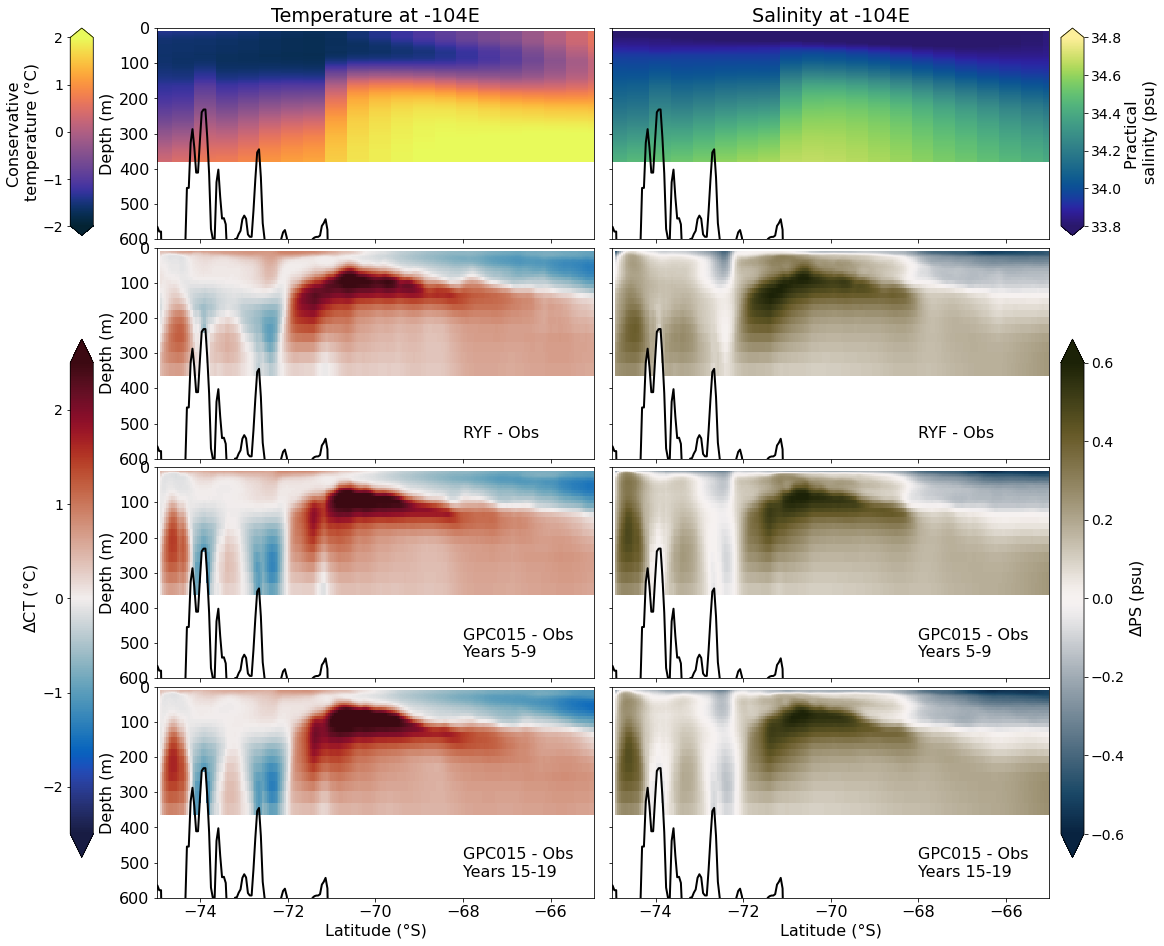

In [35]:
start_times=['2154-01-10','2164-01-10']
end_times=['2158-12-20','2168-12-20']
lon=-104 
sim, sess = TGade, basal_melt_session

fig, axes = figure_ts_transect(lon, obs_temp, obs_salt, sim, sess, start_times, end_times)

plt.show()

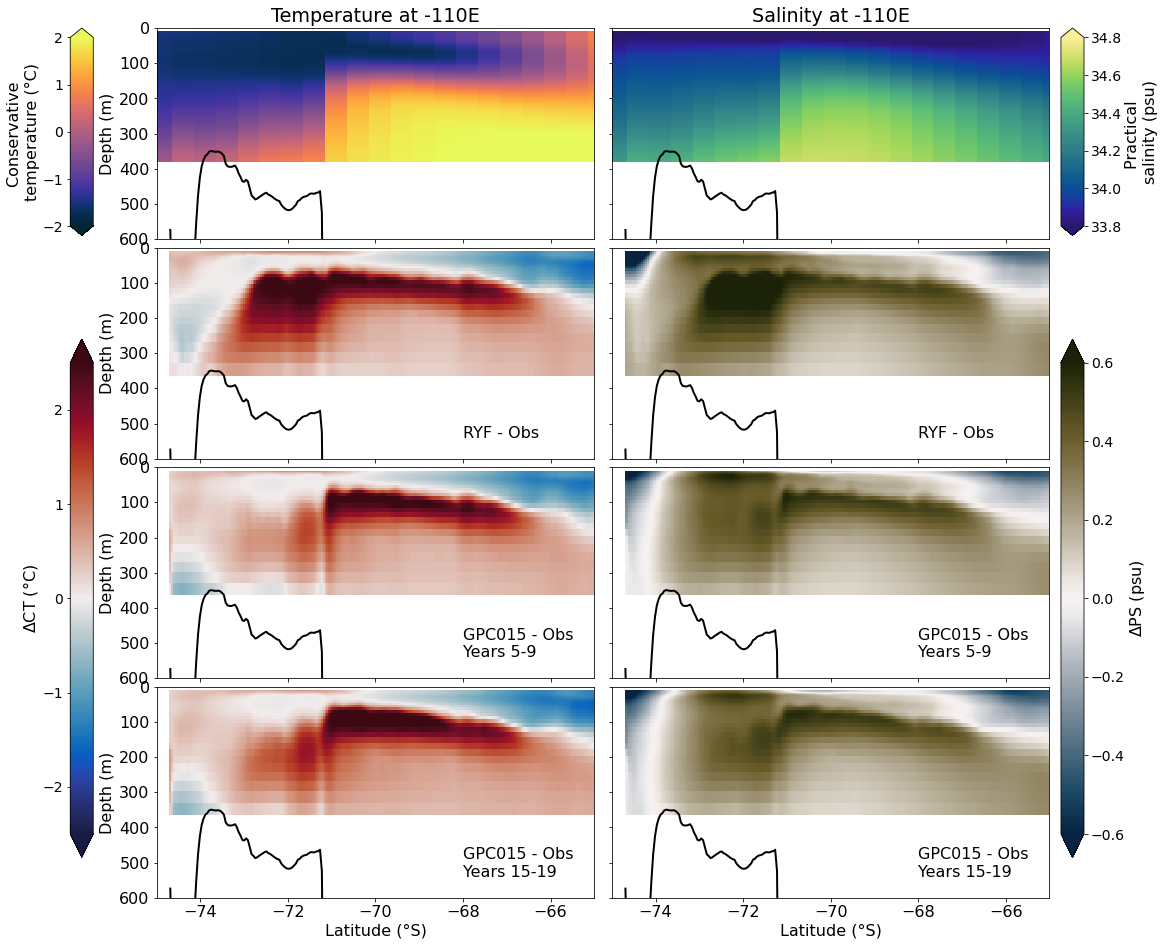

In [36]:
start_times=['2154-01-10','2164-01-10']
end_times=['2158-12-20','2168-12-20']
lon=-110
sim, sess = TGade, basal_melt_session

fig, axes = figure_ts_transect(lon, obs_temp, obs_salt, sim, sess, start_times, end_times)

plt.show()

2023-02-09 11:39:38,555 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


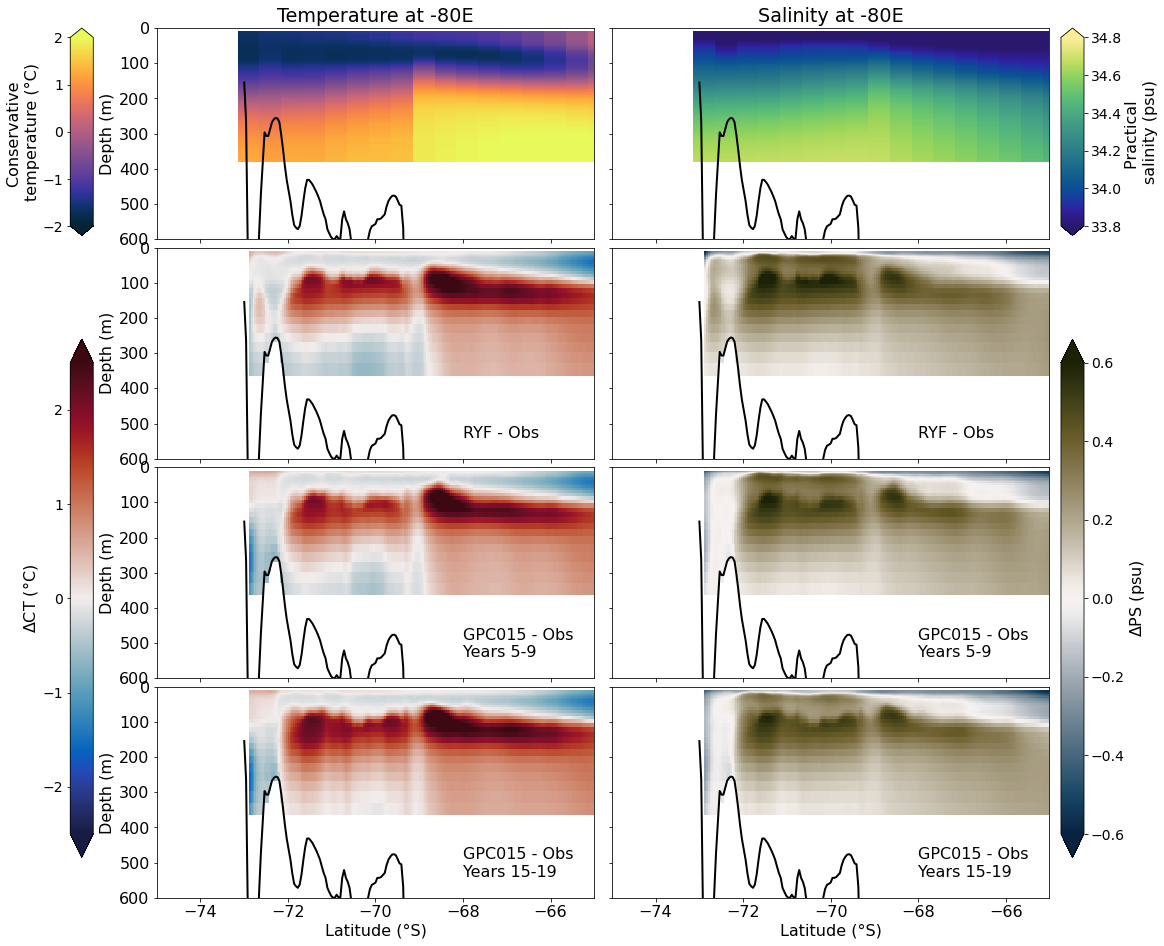

In [37]:
start_times=['2154-01-10','2164-01-10']
end_times=['2158-12-20','2168-12-20']
lon=-80
sim, sess = TGade, basal_melt_session

fig, axes = figure_ts_transect(lon, obs_temp, obs_salt, sim, sess, start_times, end_times)

plt.show()

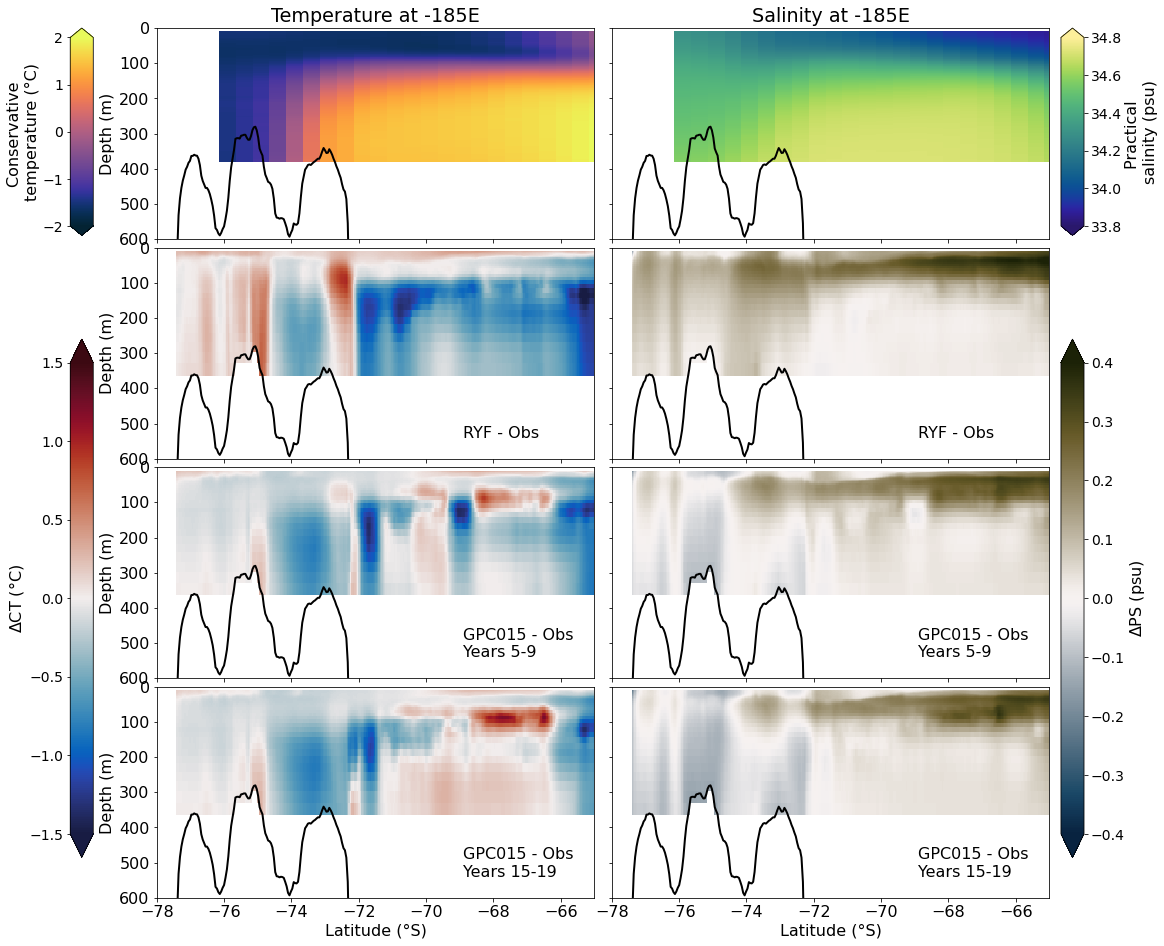

In [41]:
start_times=['2154-01-10','2164-01-10']
end_times=['2158-12-20','2168-12-20']
lon=-185
sim, sess = TGade, basal_melt_session

fig, axes = figure_ts_transect(lon, obs_temp, obs_salt, sim, sess, start_times, end_times)

plt.show()

## Schmitko observations

## Compared to RYF (not against obs)

## Original code. 

In [5]:
# build database for these experiments:
observations = 'TS_data'
session_data = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/TS_data.db'
obs_session = cc.database.create_session(session_data)
dir_TSobs = ['/g/data/e14/pc5520/TS_data/']
cc.database.build_index(dir_TSobs,obs_session)

Indexing experiment: TS_data


0

In [6]:
#Import obs
salt_obs = cc.querying.getvar(observations, 'Sal', obs_session, ncfile='TS_Climato_Antarctic60S.nc')
temp_obs = cc.querying.getvar(observations, 'Temp', obs_session, ncfile='TS_Climato_Antarctic60S.nc')

In [16]:
# database for control simulation:
#master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
#control = '01deg_jra55v13_ryf9091'

# database for perturbations:
#basal_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
#easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
#easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

In [7]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'

# realistic calving + conservative temperature + tfreezing as in GPC006 / calving put in runoff array - test
Tfreezing_min_calv_2 = 'accessom2-GPC013'

start_time='2155-01-01'
end_time='2156-01-01'

lat_slice  = slice(-80,-59)

In [8]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

In [9]:
salt_con = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_con = salt_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

salt_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_Tfreezing_min_calv_2 = salt_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

In [10]:
temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

temp_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

In [11]:
def plot_obs(zz=None,tt=None,var_simu=None,var_obs=None,var_con=None,vmin=33,vmax=35):

    fontsize=16

    fig=plt.figure(figsize=(20,16))
    
    #Find kk
    st_ocean = var_simu.st_ocean.values
    kk_sim = np.argmin(abs(st_ocean-zz))
    
    depth = var_obs.depth.values
    kk_obs = np.argmin(abs(depth-zz))
    
    norm = col.Normalize(vmin=vmin,vmax=vmax)

    #Obs temp
    
    xx, yy = np.meshgrid(var_obs.lon,var_obs.lat)

    ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    ## plot:
    cf = ax.pcolormesh(xx, yy, var_obs[:,:,tt,kk_obs].transpose(), norm=norm,
                   cmap = cmocean.cm.jet, transform = ccrs.PlateCarree())
    ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
    plt.title('Observations',fontsize=fontsize)
    #ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
    #             zorder=2,transform = ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())
    
        #### Control:
    ax = fig.add_axes([0.3, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    pcm = ax.pcolormesh(var_con.xt_ocean,var_con.yt_ocean,var_con[tt,kk_sim,:,:],norm=norm,
                       cmap = cmocean.cm.jet, transform = ccrs.PlateCarree())
    ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
    plt.title('Control',fontsize=fontsize)
    
    #### Tfreezing_min:
    ax = fig.add_axes([0.6, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    pcm = ax.pcolormesh(var_simu.xt_ocean,var_simu.yt_ocean,var_simu[tt,kk_sim,:,:],norm=norm,
                       cmap = cmocean.cm.jet, transform = ccrs.PlateCarree())
    ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
    plt.title('Tfreezing',fontsize=fontsize)
    
    # colorbar:
    cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
    cbar = plt.colorbar(pcm, cax = cbaxes, orientation = 'vertical',extend = 'both')
    #cbar.set_label(r'Temperature obs',fontsize=fontsize,labelpad=2)
    cbar.ax.tick_params(labelsize=fontsize)

In [12]:
def plot_obs_diff(zz=None,tt=None,var_simu=None,var_obs=None,var_con=None,vmin=33,vmax=35, scale_max=0.15):

    fontsize=16

    fig=plt.figure(figsize=(20,16))
    
    #Find kk
    st_ocean = var_simu.st_ocean.values
    kk_sim = np.argmin(abs(st_ocean-zz))
    
    depth = var_obs.depth.values
    kk_obs = np.argmin(abs(depth-zz))
    
    norm = col.Normalize(vmin=vmin,vmax=vmax)

    #Obs temp
    
    xx, yy = np.meshgrid(var_obs.lon,var_obs.lat)

    ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    ## plot:
    cf = ax.pcolormesh(xx, yy, var_obs[:,:,tt,kk_obs].transpose(), norm=norm,
                   cmap = cmocean.cm.jet, transform = ccrs.PlateCarree())
    ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
    plt.title('Observations',fontsize=fontsize)
    #ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
    #             zorder=2,transform = ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())
    
        #### Control:
    ax = fig.add_axes([0.3, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    pcm = ax.pcolormesh(var_con.xt_ocean,var_con.yt_ocean,var_con[tt,kk_sim,:,:],norm=norm,
                       cmap = cmocean.cm.jet, transform = ccrs.PlateCarree())
    ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
    plt.title('Control',fontsize=fontsize)
    
    #### Tfreezing_min:
    norm2 = col.Normalize(vmin=-scale_max,vmax=scale_max)
    
    ax = fig.add_axes([0.6, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    pcm = ax.pcolormesh(var_simu.xt_ocean,var_simu.yt_ocean,var_simu[tt,kk_sim,:,:] - var_con[tt,kk_sim,:,:],norm=norm2,
                       cmap = cmocean.balance, transform = ccrs.PlateCarree())
    ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
    plt.title('Tfreezing',fontsize=fontsize)
    
    # colorbar:
    cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
    cbar = plt.colorbar(pcm, cax = cbaxes, orientation = 'vertical',extend = 'both')
    #cbar.set_label(r'Temperature obs',fontsize=fontsize,labelpad=2)
    cbar.ax.tick_params(labelsize=fontsize)

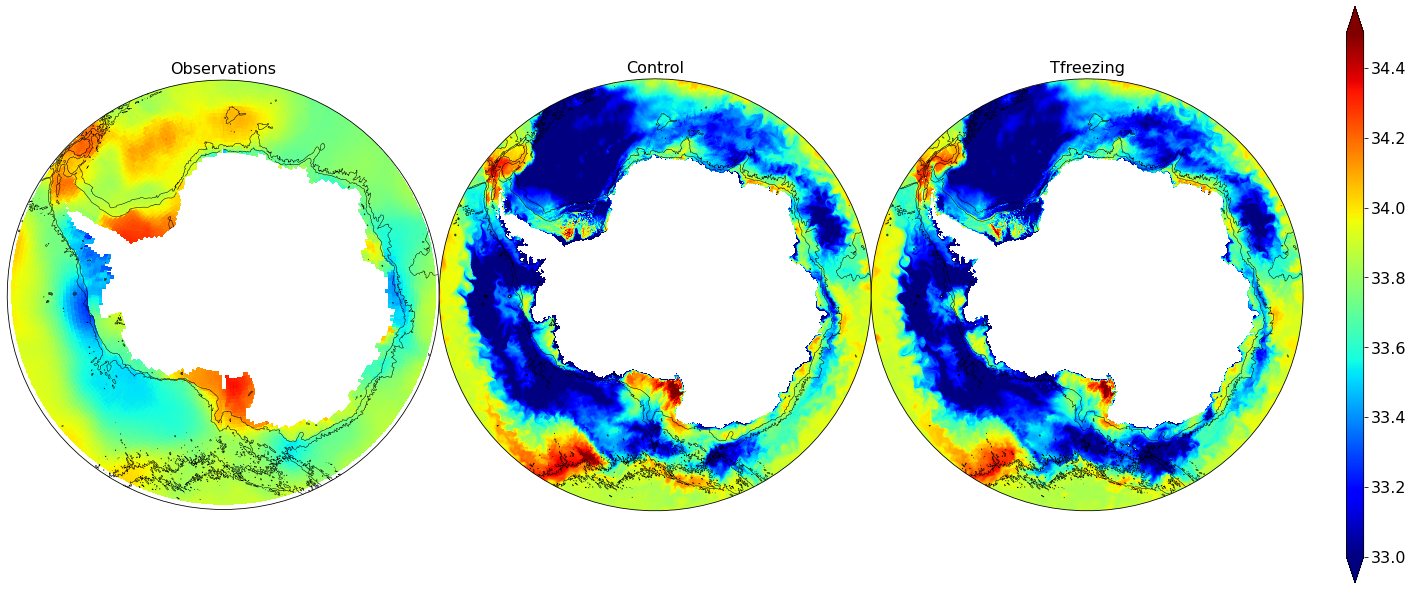

In [13]:
plot_obs(zz=10,tt=0,var_simu=salt_Tfreezing_min_calv_2,var_obs=salt_obs,var_con=salt_con,vmin=33,vmax=34.5)

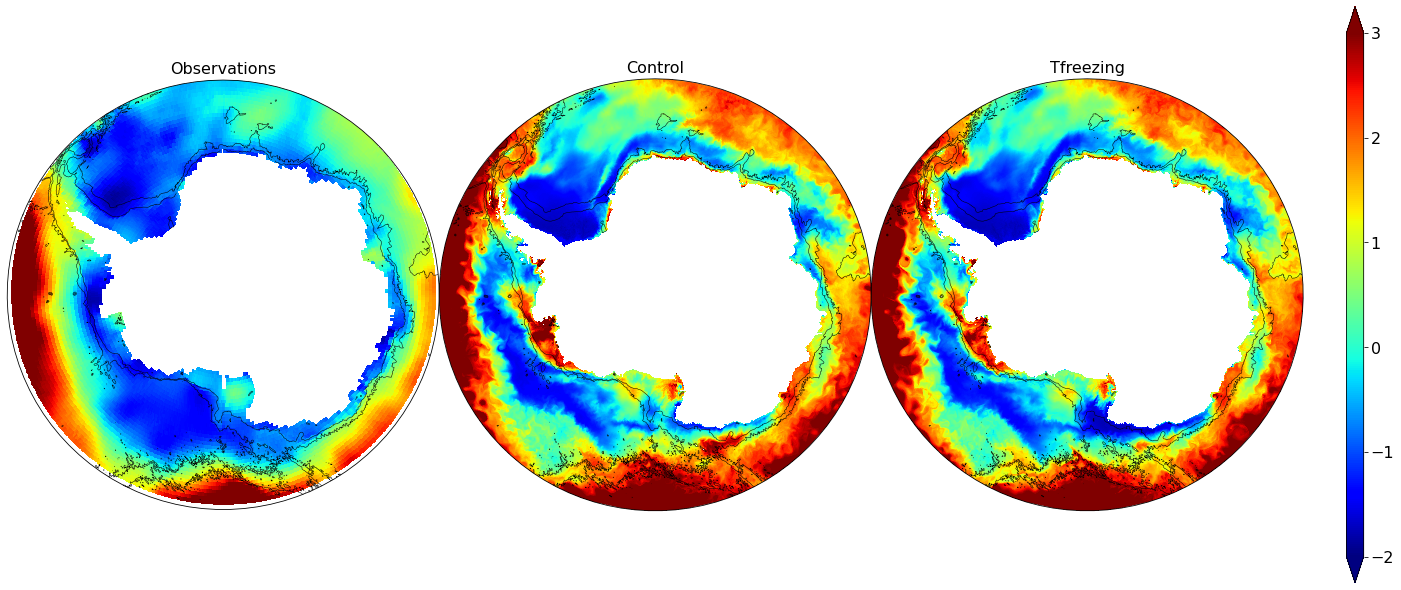

In [21]:
plot_obs(zz=10,tt=0,var_simu=temp_Tfreezing_min_calv_2,var_obs=temp_obs,var_con=temp_con,vmin=-2,vmax=3)

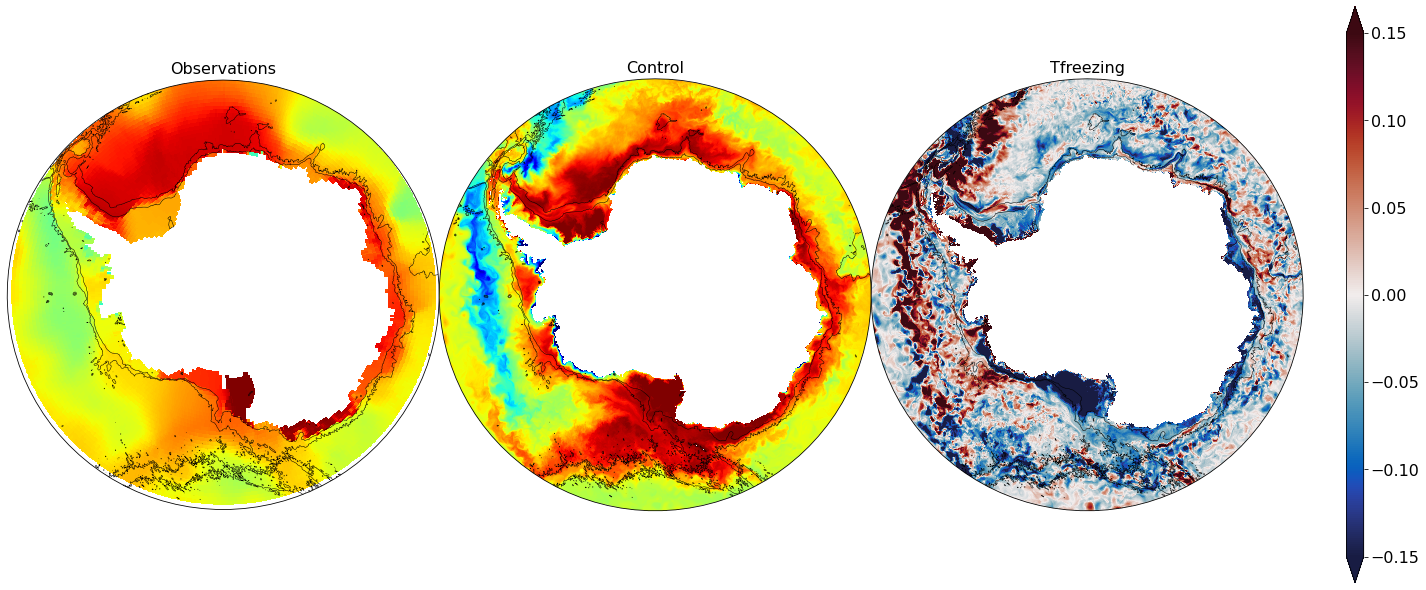

In [30]:
plot_obs_diff(zz=10,tt=6,var_simu=salt_Tfreezing_min_calv_2,var_obs=salt_obs,var_con=salt_con,vmin=33,vmax=34.5,scale_max=0.15)